### Projet détection drone 

In [78]:
import tensorflow as tf 
import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os

In [157]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)

PATH = os.path.join(os.path.dirname("train_image/drone"))
train_dir = os.path.join(PATH)

PATHTEST = os.path.join(os.path.dirname("test_image/drone"))
test_dir = os.path.join(PATHTEST)

PATHTEST_PHOTO = os.path.join(os.path.dirname("photo_test/photo"))
test_photo_dir = os.path.join(PATHTEST_PHOTO)

In [113]:
#charger le dataset de train
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 795 files belonging to 1 classes.


In [114]:
#charger le dataset de test 
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 302 files belonging to 1 classes.


In [115]:
#permet de donner le nom de la classe pour chaque image
class_names = train_dataset.class_names

Copying files: 0 files [3:53:46, ? files/s]
Copying files: 0 files [3:58:22, ? files/s]
Copying files: 0 files [3:47:13, ? files/s]


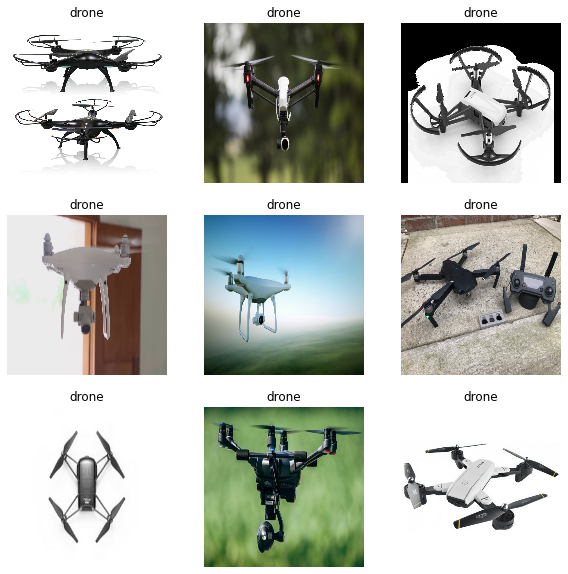

In [117]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [118]:
#prélecture tamponnée pour charger les images
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [119]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Création du modèle

In [121]:
#création du modele avec le modele mobileNet V2 
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 1s 0us/step


In [122]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [123]:
#gel de la base convolutive avant d entrainer le modele
base_model.trainable = False

In [124]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [125]:
#couche de pooling pour créer un vecteur par image 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [126]:
#convertir les caractéristiques en un seule pred par image 
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [127]:
#construction modele en redimensionnant, base model, foncitonnalité des couches 
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [128]:
#compilation du modele avant de l entrainer  
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [129]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [130]:
len(model.trainable_variables)

2

In [131]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(test_dataset)

25/25 [==============================] - 9s 271ms/step - loss: 0.9610 - accuracy: 0.5925


In [132]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.96
initial accuracy: 0.59


In [133]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset)

Epoch 1/10
25/25 [==============================] - 17s 577ms/step - loss: 0.6835 - accuracy: 0.7635 - val_loss: 0.3943 - val_accuracy: 0.9597
Epoch 2/10
25/25 [==============================] - 15s 586ms/step - loss: 0.3047 - accuracy: 0.9610 - val_loss: 0.1776 - val_accuracy: 0.9962
Epoch 3/10
25/25 [==============================] - 16s 599ms/step - loss: 0.1529 - accuracy: 0.9975 - val_loss: 0.1013 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 16s 622ms/step - loss: 0.0922 - accuracy: 1.0000 - val_loss: 0.0673 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 16s 617ms/step - loss: 0.0654 - accuracy: 1.0000 - val_loss: 0.0492 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 17s 656ms/step - loss: 0.0514 - accuracy: 1.0000 - val_loss: 0.0379 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 18s 699ms/step - loss: 0.0391 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 1.0000

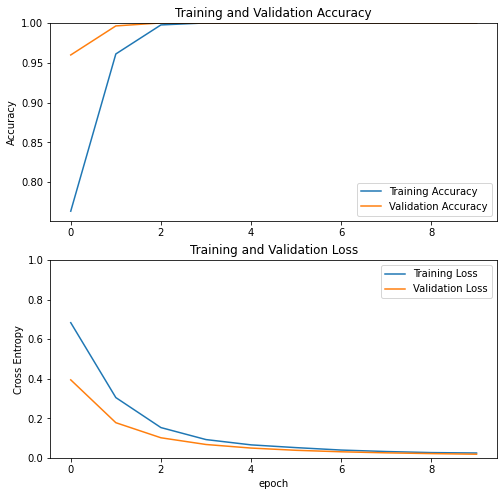

In [134]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [135]:
#dégeler le base model 
base_model.trainable = True

In [136]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [138]:
#recompiler pour que reprendre l entrainement et definir les couches inférieurs non trainable 
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [139]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [140]:
len(model.trainable_variables)

56

In [142]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)

Epoch 10/20
25/25 [==============================] - 22s 750ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 6.2032e-05 - val_accuracy: 1.0000
Epoch 11/20
25/25 [==============================] - 19s 737ms/step - loss: 4.3204e-05 - accuracy: 1.0000 - val_loss: 1.2245e-05 - val_accuracy: 1.0000
Epoch 12/20
25/25 [==============================] - 20s 768ms/step - loss: 8.9320e-06 - accuracy: 1.0000 - val_loss: 2.6203e-06 - val_accuracy: 1.0000
Epoch 13/20
25/25 [==============================] - 20s 794ms/step - loss: 2.8597e-06 - accuracy: 1.0000 - val_loss: 5.2234e-07 - val_accuracy: 1.0000
Epoch 14/20
25/25 [==============================] - 21s 822ms/step - loss: 4.6821e-07 - accuracy: 1.0000 - val_loss: 1.5153e-07 - val_accuracy: 1.0000
Epoch 15/20
25/25 [==============================] - 22s 849ms/step - loss: 1.3482e-07 - accuracy: 1.0000 - val_loss: 4.4196e-08 - val_accuracy: 1.0000
Epoch 16/20
25/25 [==============================] - 22s 855ms/step - loss: 5.5038e-08 - acc

In [143]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

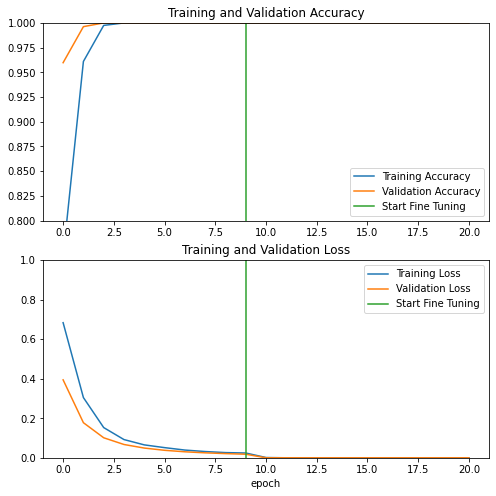

In [144]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [145]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

25/25 [==============================] - 7s 259ms/step - loss: 8.7806e-10 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


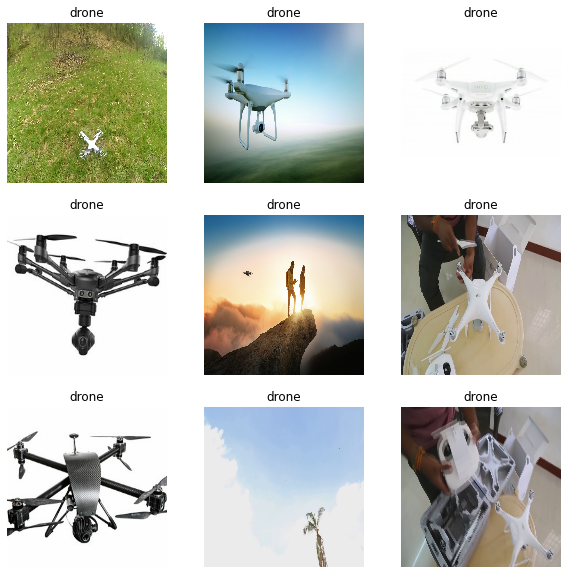

In [156]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [159]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


C:\Users\raf_user\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
